In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
data_dir = "E:/skin_cancer_dataset/dataset"
classes = ["vasc", "df", "akeic"]

X, y = [], []
for label, folder in enumerate(classes):
    folder_path = os.path.join(data_dir, folder)
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.utils.img_to_array(img)
        X.append(img_array)
        y.append(label)

X = np.array(X) / 255.0
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

data_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                              shear_range=0.1, zoom_range=0.1, horizontal_flip=True)
train_generator = data_gen.flow(X_train, y_train, batch_size=32)
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=32)

In [ ]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# base model layers
for layer in vgg19.layers:
    layer.trainable = False
for layer in densenet169.layers:
    layer.trainable = False

vgg19_features = GlobalAveragePooling2D()(vgg19.output)
densenet169_features = GlobalAveragePooling2D()(densenet169.output)

merged_features = Concatenate()([vgg19_features, densenet169_features])

x = Dense(256, activation='relu')(merged_features)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(3, activation='softmax')(x)  # Change 3 to the number of classes


model = Model(inputs=[vgg19.input, densenet169.input], outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 33,226,371 (126.75 MB)

 Trainable params: 558,595 (2.13 MB)

 Non-trainable params: 32,667,776 (124.62 MB)

In [ ]:
# Training
history = model.fit(
    [X_train, X_train], y_train,
    validation_data=([X_val, X_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)]
)

# Evaluation
val_loss, val_accuracy = model.evaluate([X_val, X_val], y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 189s 8s/step - accuracy: 0.5084 - loss: 1.4362 - val_accuracy: 0.5988 - val_loss: 0.8714 - learning_rate: 1.0000e-04
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 189s 9s/step - accuracy: 0.6834 - loss: 0.8639 - val_accuracy: 0.7901 - val_loss: 0.6474 - learning_rate: 1.0000e-04
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 163s 8s/step - accuracy: 0.7916 - loss: 0.5346 - val_accuracy: 0.8457 - val_loss: 0.5060 - learning_rate: 1.0000e-04
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 163s 8s/step - accuracy: 0.8324 - loss: 0.3913 - val_accuracy: 0.8519 - val_loss: 0.4410 - learning_rate: 1.0000e-04
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 165s 8s/step - accuracy: 0.8615 - loss: 0.3386 - val_accuracy: 0.8642 - val_loss: 0.3662 - learning_rate: 1.0000e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 162s 8s/step - accuracy: 0.8837 - loss: 0.3402 - val_accuracy: 0.8827 - val_loss: 0.3139 - learning_rate: 1.0000e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 163s 8s/step - accuracy: 

In [8]:
model.save("hybrid_vgg19_densenet169.keras")

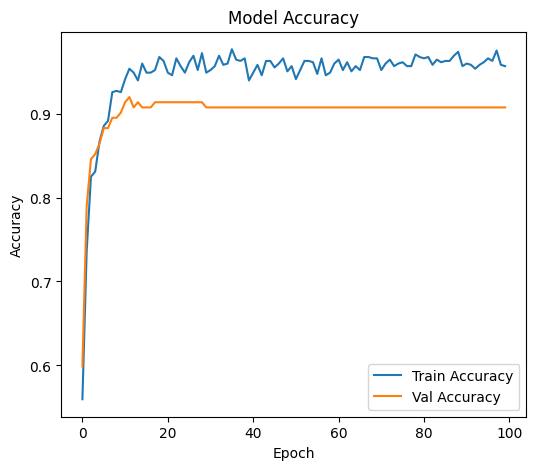

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

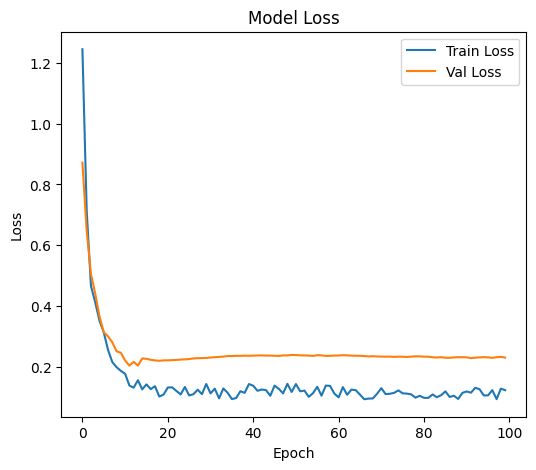

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()